In [1]:
from __future__ import print_function

import numpy as np
from scipy.sparse import lil_matrix

In [2]:
def read_bal_data(file_name):
    with open(file_name, "rt") as file:
        n_cameras, n_points, n_observations = map(
            int, file.readline().split())

        camera_indices = np.empty(n_observations, dtype=int)
        point_indices = np.empty(n_observations, dtype=int)
        points_2d = np.empty((n_observations, 2))

        for i in range(n_observations):
            camera_index, point_index, x, y = file.readline().split()
            camera_indices[i] = int(camera_index)
            point_indices[i] = int(point_index)
            points_2d[i] = [float(x), float(y)]

        camera_params = np.empty(n_cameras * 9)
        for i in range(n_cameras * 9):
            camera_params[i] = float(file.readline())
        camera_params = camera_params.reshape((n_cameras, -1))

        points_3d = np.empty(n_points * 3)
        for i in range(n_points * 3):
            points_3d[i] = float(file.readline())
        points_3d = points_3d.reshape((n_points, -1))

    return camera_params, points_3d, camera_indices, point_indices, points_2d

In [3]:
camera_params, points_3d, camera_indices, point_indices, points_2d = read_bal_data('./data/ba/ba1.txt')
print("camera_params :", len(camera_params))
print("points_3d :",len(points_3d))
print("camera_indices :",len(camera_indices))
print("point_indices :",len(point_indices))
print("points_2d :",len(points_2d))

camera_params : 49
points_3d : 7776
camera_indices : 31843
point_indices : 31843
points_2d : 31843


In [4]:
point_indices

array([   0,    0,    0, ..., 7774, 7775, 7775])

In [5]:
camera_indices

array([ 0,  1,  3, ..., 48, 47, 48])

In [6]:
n_cameras = camera_params.shape[0]
n_points = points_3d.shape[0]

n = 9 * n_cameras + 3 * n_points
m = 2 * points_2d.shape[0]

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))
print("Total number of parameters: {}".format(n))
print("Total number of residuals: {}".format(m))

n_cameras: 49
n_points: 7776
Total number of parameters: 23769
Total number of residuals: 63686


In [7]:
def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.
    
    Rodrigues' rotation formula is used.
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis]
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    return cos_theta * points + sin_theta * np.cross(v, points) + dot * (1 - cos_theta) * v

In [8]:
def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""
    points_proj = rotate(points, camera_params[:, :3])
    points_proj += camera_params[:, 3:6]
    points_proj = -points_proj[:, :2] / points_proj[:, 2, np.newaxis]
    f = camera_params[:, 6]
    k1 = camera_params[:, 7]
    k2 = camera_params[:, 8]
    n = np.sum(points_proj**2, axis=1)
    r = 1 + k1 * n + k2 * n**2
    points_proj *= (r * f)[:, np.newaxis]
    return points_proj

In [9]:
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """
    
    camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
    points_3d = params[n_cameras * 9:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return (points_proj - points_2d).ravel()


In [10]:
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = camera_indices.size * 2
    n = n_cameras * 9 + n_points * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 9 + s] = 1
        A[2 * i + 1, camera_indices * 9 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1

    return A

In [11]:
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

In [13]:
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)

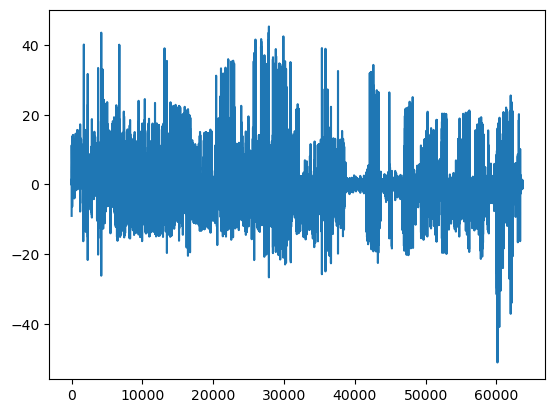

In [14]:
plt.plot(f0)

In [15]:
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)

In [16]:
import time
from scipy.optimize import least_squares

In [17]:
t0 = time.time()
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.5091e+05                                    8.57e+06    
       1              3         5.0985e+04      8.00e+05       1.46e+02       1.15e+06    
       2              4         1.6077e+04      3.49e+04       2.59e+01       2.43e+05    
       3              5         1.4163e+04      1.91e+03       2.86e+02       1.21e+05    
       4              7         1.3695e+04      4.67e+02       1.32e+02       2.51e+04    
       5              8         1.3481e+04      2.14e+02       2.25e+02       1.54e+04    
       6              9         1.3436e+04      4.55e+01       3.18e+02       2.73e+04    
       7             10         1.3422e+04      1.38e+01       6.84e+01       2.20e+03    
       8             11         1.3418e+04      3.70e+00       1.28e+02       7.91e+03    
       9             12         1.3414e+04      4.21e+00       2.64e+01       6.21e+02    

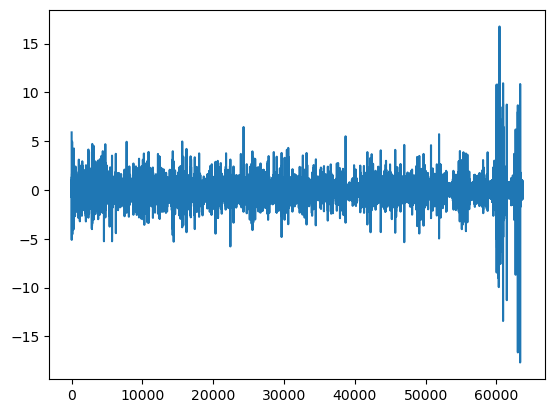

In [18]:
plt.plot(res.fun)

In [19]:
point_indices

array([   0,    0,    0, ..., 7774, 7775, 7775])

In [20]:

camera_indices

array([ 0,  1,  3, ..., 48, 47, 48])

In [21]:
points_3d[0]

array([-0.61200016,  0.57175905, -1.84708128])

In [ ]:
params= res.x
camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
points_3d = params[n_cameras * 9:].reshape((n_points, 3))
points_proj = project(points_3d[point_indices], camera_params[camera_indices])


[[-0.61187524  0.56641196 -1.85421518]
 [-0.61187524  0.56641196 -1.85421518]
 [-0.61187524  0.56641196 -1.85421518]
 ...
 [-0.90749427  0.08813529 -4.5493682 ]
 [-0.81126035  0.04386763 -4.84841847]
 [-0.81126035  0.04386763 -4.84841847]]
[[ 1.76421646e-02 -5.93720137e-03 -7.97092195e-03 ...  3.99921644e+02
  -2.44297680e-02  1.48873397e-03]
 [ 1.76141080e-02 -1.79938603e-02 -1.28037219e-02 ...  4.02709576e+02
  -2.72146440e-02  3.61385632e-03]
 [ 1.72305499e-02 -1.32476970e-02 -5.35563095e-03 ...  4.00754706e+02
  -2.67574905e-02  1.95053697e-03]
 ...
 [ 7.30038721e-03 -1.24054709e+00  2.32843682e-02 ...  4.04117154e+02
   4.51229063e-03 -1.61330903e-03]
 [ 1.41005278e-02  2.11818916e-02  2.35357666e-03 ...  3.90051726e+02
  -3.15138111e-02  3.15099815e-03]
 [ 7.30038721e-03 -1.24054709e+00  2.32843682e-02 ...  4.04117154e+02
   4.51229063e-03 -1.61330903e-03]]



In [ ]:
points_3d[point_indices[0:6]]

array([[-0.61187524,  0.56641196, -1.85421518],
       [-0.61187524,  0.56641196, -1.85421518],
       [-0.61187524,  0.56641196, -1.85421518],
       [-0.61187524,  0.56641196, -1.85421518],
       [-0.61187524,  0.56641196, -1.85421518],
       [-0.61187524,  0.56641196, -1.85421518]])

In [ ]:
point_indices[0:6]

array([0, 0, 0, 0, 0, 0])

In [ ]:
np.where(point_indices == 0)[0]

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [ ]:
x = np.array([1,10,2,10,3,10,4,5,6,7,8])
np.where(x != 10)

(array([ 0,  2,  4,  6,  7,  8,  9, 10], dtype=int64),)

In [ ]:
m = camera_indices.size * 2
n = n_cameras * 9 + n_points * 3
A = lil_matrix((m, n), dtype=int)

i = np.arange(camera_indices.size)
for s in range(9):
    A[2 * i, camera_indices * 9 + s] = 1
    A[2 * i + 1, camera_indices * 9 + s] = 1

for s in range(3):
    A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
    A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1
        



In [ ]:
print(2 * i[:20])
print(2 * i[:20] + 1)
print()
print(camera_indices[:20] * 9 )
print(camera_indices[:20] * 9 + 8)

[ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38]
[ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39]

[  0   9  27 234 261 324   0   9  36  72 180 342 423   0   9  18  27  36
  45  54]
[  8  17  35 242 269 332   8  17  44  80 188 350 431   8  17  26  35  44
  53  62]


In [ ]:
A.rows[12]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 444, 445, 446]

In [ ]:
n_cameras * 9 + point_indices * 3

array([  441,   441,   441, ..., 23763, 23766, 23766])

In [ ]:
camera_indices[:20] * 9 + 1

array([  1,  10,  28, 235, 262, 325,   1,  10,  37,  73, 181, 343, 424,
         1,  10,  19,  28,  37,  46,  55])

In [ ]:
A.toarray()[12][:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:

np.where(A.toarray()[1] == 1)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8, 441, 442, 443],
       dtype=int64),)

In [ ]:
np.where(point_indices == 0)

(array([0, 1, 2, 3, 4, 5], dtype=int64),)

In [ ]:
res.x